In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.0'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [21]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [22]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [23]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [24]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [25]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [26]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [27]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-06 14:05:16.601982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 14:05:17.648011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1202 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:02:00.0, compute capability: 7.5


In [28]:
len(folds)

5

### Check data

In [29]:
for x,y in folds[0][0].take(1):
    pass

In [30]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[8.28712997e+01, 6.87214890e+01, 4.75332985e+01],
         [8.13162308e+01, 6.91876297e+01, 4.94159508e+01],
         [8.26246033e+01, 6.34402275e+01, 4.80635338e+01],
         ...,
         [9.25321341e-01, 0.00000000e+00, 0.00000000e+00],
         [1.08478713e+00, 5.02498806e-01, 0.00000000e+00],
         [0.00000000e+00, 1.00206685e+00, 0.00000000e+00]],

        [[7.94726639e+01, 6.90237732e+01, 4.65436172e+01],
         [7.93443298e+01, 6.87248306e+01, 4.77144127e+01],
         [7.80165024e+01, 6.17089310e+01, 4.52089844e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.80868614e+00],
         [0.00000000e+00, 2.74365997e+00, 3.54030132e-01]],

        [[8.38391647e+01, 6.81033554e+01, 4.76478348e+01],
         [8.29098816e+01, 6.45873108e+01, 4.85802231e+01],
         [7.89595566e+01, 6.99377670e+01, 4.27118759e+01],
         ...,
         [1

In [31]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

<IPython.core.display.Javascript object>


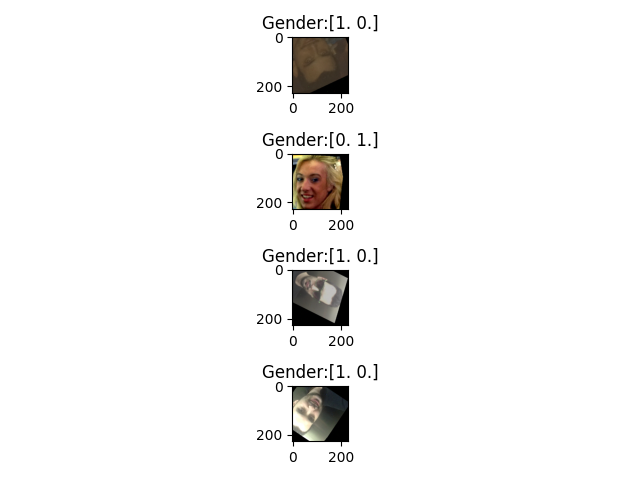

In [32]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [33]:
def createModel():
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    conv1 = tf.keras.layers.Conv2D(64, 7, strides=(4,4), activation='relu', name='conv1')
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool1')

    conv2 = tf.keras.layers.Conv2D(128, 5, activation='relu', name='conv2')
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool2')

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', name='conv3')
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool3')

    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = inp / 127.5 - 1.0
    
    o = conv1(o)
    o = pool1(o)

    o = conv2(o)
    o = pool2(o)

    o = conv3(o)
    o = pool3(o)

    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='CNN_1')
    
    return model

In [34]:
model = createModel()

In [35]:
model.summary()

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 conv1 (Conv2D)              (None, 56, 56, 64)        9472      
                                                                 
 pool1 (MaxPooling2D)        (None, 27, 27, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 128)       204928

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/CNN_5"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.000001, clipvalue=0.1)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-06 14:06:15.852505: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 14:06:15.852545: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-06 14:06:15.852578: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-06 14:06:15.854795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/home/ntcadmin/env/trt-11.0/TensorRT-7.1.3.4/lib:
2022-11-06 14:06:15.855128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/home/ntcadmin/env/trt-11.0/TensorRT-7.1.3.4/lib:
2022-11-06 14:06:15.855194: 

3528/3528 [==============================] - 19s 5ms/step - loss: 0.6970 - accuracy: 0.4764
Epoch 1/300
  16/1000 [..............................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5625

2022-11-06 14:06:36.719447: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 14:06:36.719485: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-06 14:06:36.719548: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2022-11-06 14:06:36.719568: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:184] cuptiSubscribe: ignored due to a previous error.
2022-11-06 14:06:36.719575: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2022-11-06 14:06:36.719580: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1716] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2022-11-06 14:06:36.783011: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-06 14:06

1000/1000 [==============================] - 27s 26ms/step - loss: 0.6946 - accuracy: 0.5230 - val_loss: 0.6909 - val_accuracy: 0.5348
Epoch 2/300
   7/1000 [..............................] - ETA: 9s - loss: 0.7232 - accuracy: 0.3214

2022-11-06 14:07:02.115746: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49152000 exceeds 10% of free system memory.
2022-11-06 14:07:02.142556: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.
2022-11-06 14:07:02.172923: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.


1000/1000 [==============================] - 25s 25ms/step - loss: 0.6943 - accuracy: 0.5125 - val_loss: 0.6887 - val_accuracy: 0.5365
Epoch 3/300
   6/1000 [..............................] - ETA: 9s - loss: 0.6921 - accuracy: 0.4583 

2022-11-06 14:07:27.238799: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49152000 exceeds 10% of free system memory.
2022-11-06 14:07:27.261682: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.


1000/1000 [==============================] - 25s 25ms/step - loss: 0.6862 - accuracy: 0.5512 - val_loss: 0.6878 - val_accuracy: 0.5608
Epoch 4/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6882 - accuracy: 0.5418 - val_loss: 0.6864 - val_accuracy: 0.5564
Epoch 5/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6934 - accuracy: 0.5070 - val_loss: 0.6857 - val_accuracy: 0.5662
Epoch 6/300
1000/1000 [==============================] - 26s 26ms/step - loss: 0.6769 - accuracy: 0.5765 - val_loss: 0.6873 - val_accuracy: 0.5335
Epoch 7/300
1000/1000 [==============================] - 25s 26ms/step - loss: 0.6902 - accuracy: 0.5370 - val_loss: 0.6862 - val_accuracy: 0.5338
Epoch 8/300
1000/1000 [==============================] - 32s 32ms/step - loss: 0.6906 - accuracy: 0.5303 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 9/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6895 - accuracy: 0.5418 - val_loss: 0.6822 - val_

1000/1000 [==============================] - 31s 31ms/step - loss: 0.6734 - accuracy: 0.5817 - val_loss: 0.6623 - val_accuracy: 0.6132
Epoch 59/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6605 - accuracy: 0.6200 - val_loss: 0.6649 - val_accuracy: 0.5873
Epoch 60/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6770 - accuracy: 0.5717 - val_loss: 0.6684 - val_accuracy: 0.5781
Epoch 61/300
1000/1000 [==============================] - 26s 26ms/step - loss: 0.6793 - accuracy: 0.5655 - val_loss: 0.6623 - val_accuracy: 0.6141
Epoch 62/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6807 - accuracy: 0.5738 - val_loss: 0.6634 - val_accuracy: 0.5964
Epoch 63/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6679 - accuracy: 0.5905 - val_loss: 0.6641 - val_accuracy: 0.6121
Epoch 64/300
1000/1000 [==============================] - 23s 23ms/step - loss: 0.6763 - accuracy: 0.5725 - val_loss: 0.6616 

1000/1000 [==============================] - 24s 24ms/step - loss: 0.6722 - accuracy: 0.5817 - val_loss: 0.6513 - val_accuracy: 0.6311
Epoch 114/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6720 - accuracy: 0.5845 - val_loss: 0.6532 - val_accuracy: 0.6297
Epoch 115/300
1000/1000 [==============================] - 22s 22ms/step - loss: 0.6724 - accuracy: 0.5985 - val_loss: 0.6535 - val_accuracy: 0.6107
Epoch 116/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6576 - accuracy: 0.6005 - val_loss: 0.6508 - val_accuracy: 0.6294
Epoch 117/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6773 - accuracy: 0.5750 - val_loss: 0.6557 - val_accuracy: 0.6284
Epoch 118/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6652 - accuracy: 0.5935 - val_loss: 0.6536 - val_accuracy: 0.6281
Epoch 119/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6482 - accuracy: 0.6267 - val_loss: 0

1000/1000 [==============================] - 25s 25ms/step - loss: 0.6649 - accuracy: 0.6047 - val_loss: 0.6525 - val_accuracy: 0.6077
Epoch 169/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6503 - accuracy: 0.6083 - val_loss: 0.6438 - val_accuracy: 0.6388
Epoch 170/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6682 - accuracy: 0.5857 - val_loss: 0.6447 - val_accuracy: 0.6391
Epoch 171/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6517 - accuracy: 0.6208 - val_loss: 0.6708 - val_accuracy: 0.5709
Epoch 172/300
1000/1000 [==============================] - 26s 26ms/step - loss: 0.6464 - accuracy: 0.6273 - val_loss: 0.6462 - val_accuracy: 0.6219
Epoch 173/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6690 - accuracy: 0.5813 - val_loss: 0.6443 - val_accuracy: 0.6409
Epoch 174/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6678 - accuracy: 0.5940 - val_loss: 0

1000/1000 [==============================] - 25s 25ms/step - loss: 0.6666 - accuracy: 0.5828 - val_loss: 0.6393 - val_accuracy: 0.6404
Epoch 224/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6551 - accuracy: 0.6195 - val_loss: 0.6409 - val_accuracy: 0.6452
Epoch 225/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6380 - accuracy: 0.6352 - val_loss: 0.6408 - val_accuracy: 0.6313
Epoch 226/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6630 - accuracy: 0.6000 - val_loss: 0.6397 - val_accuracy: 0.6460
Epoch 227/300
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6633 - accuracy: 0.5930 - val_loss: 0.6373 - val_accuracy: 0.6470
Epoch 228/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6586 - accuracy: 0.6137 - val_loss: 0.6657 - val_accuracy: 0.5871
Epoch 229/300
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6487 - accuracy: 0.6120 - val_loss: 0

1000/1000 [==============================] - 17s 17ms/step - loss: 0.6311 - accuracy: 0.6410 - val_loss: 0.6507 - val_accuracy: 0.6148
Epoch 279/300
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6624 - accuracy: 0.5938 - val_loss: 0.6363 - val_accuracy: 0.6385
Epoch 280/300
1000/1000 [==============================] - 16s 16ms/step - loss: 0.6518 - accuracy: 0.6208 - val_loss: 0.6413 - val_accuracy: 0.6353
Epoch 281/300
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6450 - accuracy: 0.6292 - val_loss: 0.7050 - val_accuracy: 0.5663
Epoch 282/300
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6547 - accuracy: 0.6160 - val_loss: 0.6471 - val_accuracy: 0.6124
Epoch 283/300
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6671 - accuracy: 0.5850 - val_loss: 0.6331 - val_accuracy: 0.6508
Epoch 284/300
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6475 - accuracy: 0.6360 - val_loss: 0